<a href="https://colab.research.google.com/github/HedersonSantos/SmartHome/blob/main/seriesTemporais.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [58]:
!pip install pmdarima

In [59]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from datetime import datetime



from statsmodels.tsa.stattools import acovf, acf, pacf, pacf_yw, pacf_ols
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf # para determinar (p,q)
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.tools import diff
from statsmodels.tsa.stattools import adfuller

from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.forecasting.theta import ThetaModel

from pmdarima.arima.utils import ndiffs
from pmdarima import auto_arima


from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

from sklearn.metrics import mean_squared_error,mean_absolute_error
from sklearn.preprocessing import MinMaxScaler


In [60]:
#!wget https://raw.githubusercontent.com/HedersonSantos/SmartHome/main/train.csv
#!wget https://raw.githubusercontent.com/HedersonSantos/SmartHome/main/test.csv
#!wget https://raw.githubusercontent.com/HedersonSantos/SmartHome/main/sample_submission.csv

In [61]:
!head train.csv

Id,Date,Time,CO2_(dinning-room),CO2_room,Relative_humidity_(dinning-room),Relative_humidity_room,Lighting_(dinning-room),Lighting_room,Meteo_Rain,Meteo_Sun_dusk,Meteo_Wind,Meteo_Sun_light_in_west_facade,Meteo_Sun_light_in_east_facade,Meteo_Sun_light_in_south_facade,Meteo_Sun_irradiance,Outdoor_relative_humidity_Sensor,Day_of_the_week,Indoor_temperature_room
0,13/03/2012,11:45,216.56,221.92,39.9125,42.415,81.665,113.52,0.0,623.36,1.42625,9690.24,12604.2,95436.8,758.88,48.375,2.0,17.8275
1,13/03/2012,12:00,219.947,220.363,39.9267,42.2453,81.7413,113.605,0.0,623.211,1.592,11022.0,10787.2,95436.8,762.069,47.808,2.0,18.1207
2,13/03/2012,12:15,219.403,218.933,39.772,42.2267,81.424,113.6,0.0,622.656,1.89133,13960.5,9669.63,95398.6,766.251,47.432,2.0,18.4367
3,13/03/2012,12:30,218.613,217.045,39.776,42.0987,81.5013,113.344,0.0,622.571,1.828,18511.2,9648.13,95360.3,766.037,47.024,2.0,18.7513
4,13/03/2012,12:45,217.714,216.08,39.7757,42.0686,81.4657,113.034,0.0,622.4,2.36071,26349.0,9208.32,9535

In [62]:
df_treino = pd.read_csv('train.csv')
df_treino['data_hora'] = df_treino.loc[:,['Date', 'Time']].apply(lambda x: datetime.strptime(x['Date'] + ' ' + x['Time'], '%d/%m/%Y %H:%M'), axis=1)
df_treino = df_treino.sort_values(by='data_hora')
df_treino = df_treino.set_index('data_hora')
idx = pd.date_range(start=df_treino.index.min(), end=df_treino.index.max(),  freq='0h15min')
df_treino= df_treino.reindex(idx)
df_treino.fillna(method='ffill', inplace=True)

In [63]:
min(df_treino.index), max(df_treino.index)

(Timestamp('2012-03-13 11:45:00', freq='15T'),
 Timestamp('2012-04-11 06:30:00', freq='15T'))

In [64]:
df_treino.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2764 entries, 2012-03-13 11:45:00 to 2012-04-11 06:30:00
Freq: 15T
Data columns (total 19 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Id                                2764 non-null   int64  
 1   Date                              2764 non-null   object 
 2   Time                              2764 non-null   object 
 3   CO2_(dinning-room)                2764 non-null   float64
 4   CO2_room                          2764 non-null   float64
 5   Relative_humidity_(dinning-room)  2764 non-null   float64
 6   Relative_humidity_room            2764 non-null   float64
 7   Lighting_(dinning-room)           2764 non-null   float64
 8   Lighting_room                     2764 non-null   float64
 9   Meteo_Rain                        2764 non-null   float64
 10  Meteo_Sun_dusk                    2764 non-null   float64
 11  Meteo_Wind             

In [65]:
df_treino.groupby('Date')['Id'].count().reset_index().sort_values('Date')

,Date,Id
0,01/04/2012,96
1,02/04/2012,96
2,03/04/2012,96
3,04/04/2012,96
4,05/04/2012,96
5,06/04/2012,96
6,07/04/2012,96
7,08/04/2012,96
8,09/04/2012,96
9,10/04/2012,96


In [66]:
df_treino = df_treino[df_treino['Date']!="13/03/2012"]
df_treino = df_treino[df_treino['Date']!="11/04/2012"]

In [67]:
df_treino.head(3)

,Id,Date,Time,CO2_(dinning-room),CO2_room,Relative_humidity_(dinning-room),Relative_humidity_room,Lighting_(dinning-room),Lighting_room,Meteo_Rain,Meteo_Sun_dusk,Meteo_Wind,Meteo_Sun_light_in_west_facade,Meteo_Sun_light_in_east_facade,Meteo_Sun_light_in_south_facade,Meteo_Sun_irradiance,Outdoor_relative_humidity_Sensor,Day_of_the_week,Indoor_temperature_room
2012-03-14 00:00:00,49,14/03/2012,00:00,217.835,223.381,41.4320,43.1573,11.6053,13.0207,0.0,0.650,0.0,0.0,0.0,0.0,-3.25067,57.5627,2.06667,19.5260
2012-03-14 00:15:00,50,14/03/2012,00:15,219.115,223.637,41.0427,43.1600,11.6053,13.5413,0.0,0.650,0.0,0.0,0.0,0.0,-3.31600,57.4720,3.00000,19.3733
2012-03-14 00:30:00,51,14/03/2012,00:30,219.200,225.131,41.0133,43.1520,11.5240,13.1027,0.0,0.738,0.0,0.0,0.0,0.0,-3.44667,57.7253,3.00000,19.2087


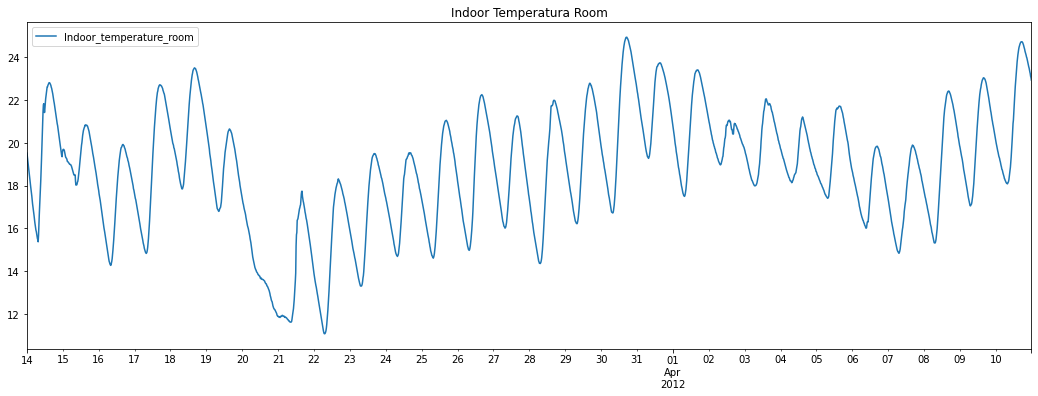

In [68]:
df_treino[['Indoor_temperature_room']].plot(figsize=(18,6), title='Indoor Temperatura Room')

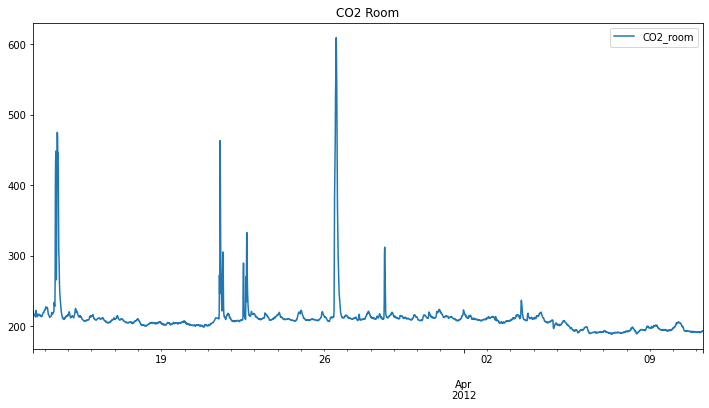

In [9]:
df_treino[['CO2_room']].plot(figsize=(12,6), title='CO2 Room')

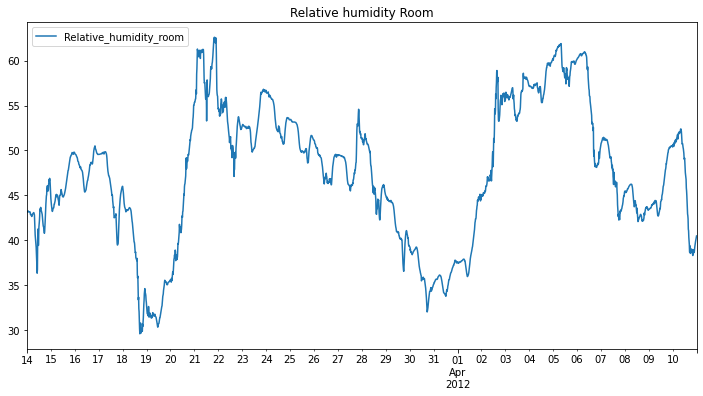

In [69]:
df_treino[['Relative_humidity_room']].plot(figsize=(12,6), title='Relative humidity Room')

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


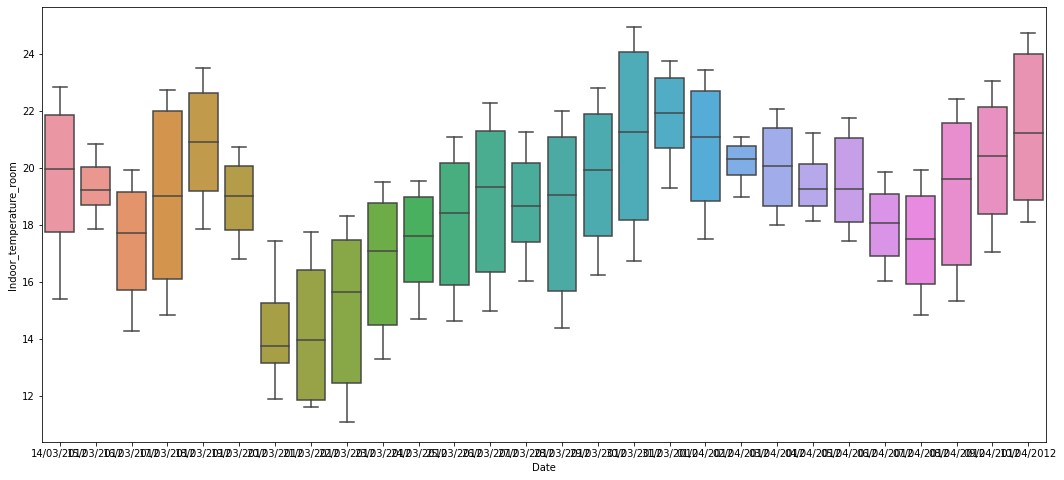

In [70]:
fig, ax = plt.subplots(figsize=(18,8))
sns.boxplot(df_treino['Date'],df_treino['Indoor_temperature_room'], ax=ax)

In [71]:
#Teste de Dickey-Fuller para confirmar a (não) estacionariedade
result = adfuller(df_treino['Indoor_temperature_room'], autolag='AIC')
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
  print('\t%s: %.3f' % (key, value))

ADF Statistic: -5.486054
p-value: 0.000002
Critical Values:
	1%: -3.433
	5%: -2.863
	10%: -2.567


O teste Dickey-Fuller mostrou que a série é estacionária, pois p-value < 0.05. 
Este teste tem H0 como: a série é não estacionária e contém uma raiz unitária. E H1 como: a série é estacionária ou tendência estacionária. Quando o p-value é pequeno, p < 0.05, rejeita-se H0 e portanto há evidências de que a série é estacionária ou tendência-estacionária. Caso p>=0.05, não se rejeita H0 e a série não é estacionária e contém uma raiz unitária.
Contudo observamos nos gráficos de linha e de boxplot por dia que a media, variância e autocovariância não são fixas. 

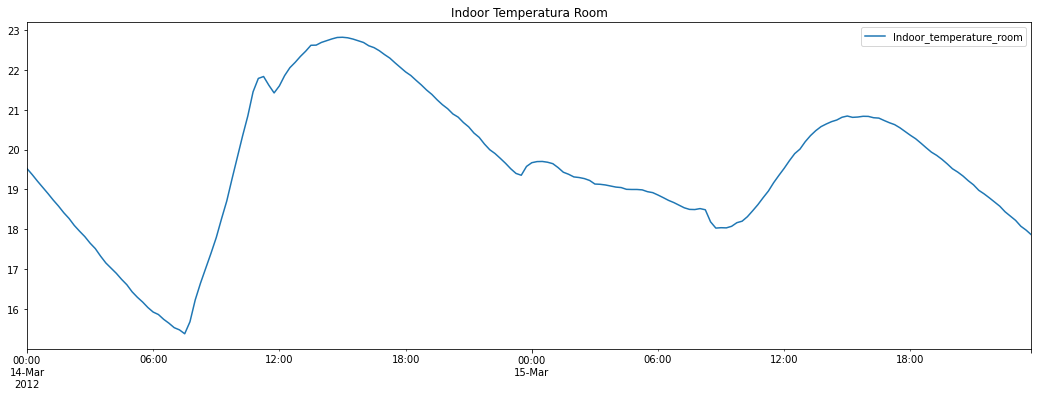

In [74]:
dftmp = df_treino[(df_treino['Date'] >= '14/03/2012') & (df_treino['Date'] <= '15/03/2012')]
dftmp[['Indoor_temperature_room']].plot(figsize=(18,6), title='Indoor Temperatura Room')



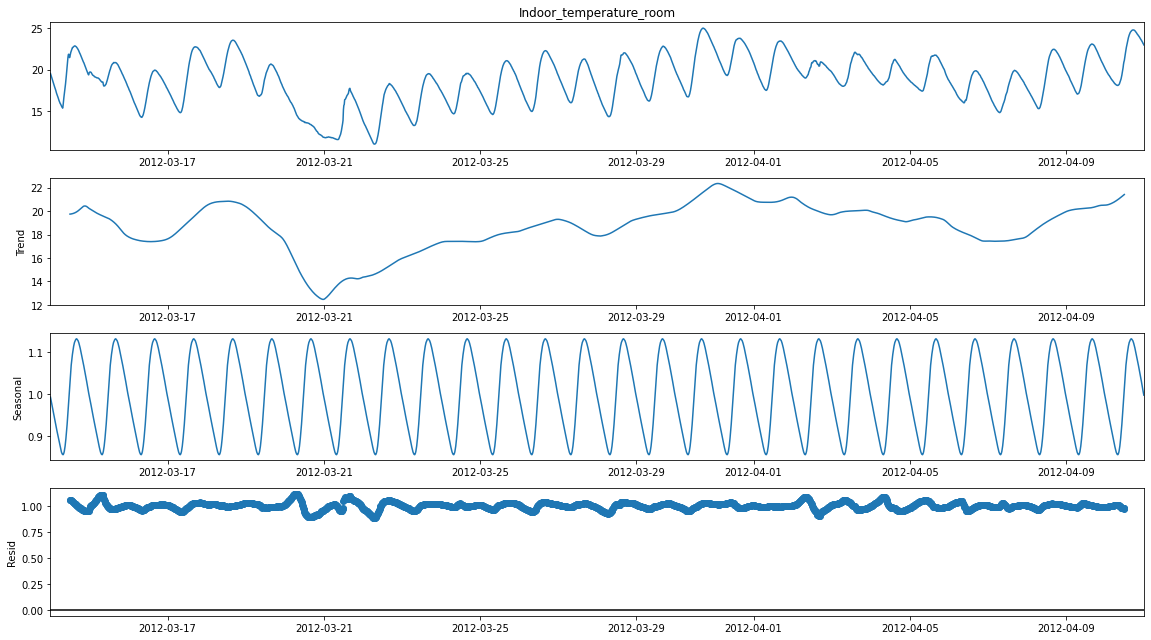

In [80]:
#Decomposição da Indoor_temperature_room em tendência e sazonalidade.
result = seasonal_decompose(df_treino['Indoor_temperature_room'], model='multiplicative', period=96 )
fig = result.plot()
fig.set_size_inches((16, 9))
fig.tight_layout()
plt.show()

/usr/local/lib/python3.7/dist-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


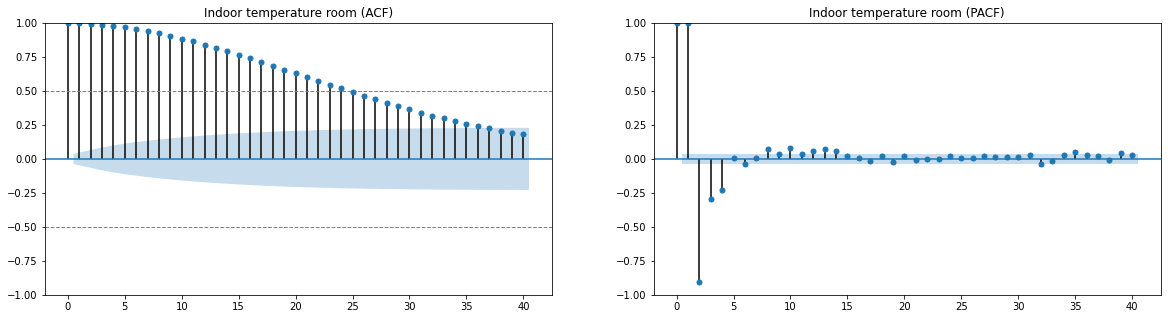

/usr/local/lib/python3.7/dist-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


In [78]:
fig, axes = plt.subplots(nrows=1, ncols=2, sharex=False, sharey=False, figsize=(20, 5))
title = 'Indoor temperature room'
lags = 40
for ax in axes:
  # define os limites de -1 e 1 para o eixo y com folga de 0.1
  ax.set_ylim(bottom=-1.1, top=1.1)
  # plota linha constante horizontal no eixo y em 0.5 para referencia 
  ax.axhline(y=0.5, xmin=0, xmax=lags, linewidth=1, color='gray', ls="--")
  ax.axhline(y=-0.5, xmin=0, xmax=lags, linewidth=1, color='gray', ls="--")

  plot_acf(df_treino['Indoor_temperature_room'], lags=lags, title=f"{title} (ACF)", ax=axes[0])
  plot_pacf(df_treino['Indoor_temperature_room'], lags=lags, title=f"{title} (PACF)", ax=axes[1])
  plt.show()
